In [119]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import catboost

import eli5
from eli5.sklearn import PermutationImportance

In [50]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [76]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [77]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [78]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

In [79]:
# 열에서 모든 값이 nan이면 train, test에서 열 제거
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique() == 0 or list(train_df[x].unique()) == [0]:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
        elif train_df[x].nunique() == 1 and test_df[x].nunique() == 1 and train_df[x].unique()[0] == 0 and test_df[x].unique()[0] == 0:
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [80]:
train, test = remove_col(train, test)

In [81]:
train.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test = test[train.columns[1:]]

In [82]:
train_x, train_y = train.drop(columns=['Y_Class']), train['Y_Class']

In [83]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


In [84]:
# stscaler = StandardScaler().fit(train_x_A)
# train_x_A = pd.DataFrame(stscaler.transform(train_x_A), columns=train_x_A.columns)
# test_A = pd.DataFrame(stscaler.transform(test_A), columns=test_A.columns)
# test_A.head()

# stscaler = StandardScaler().fit(train_x_T)
# train_x_T = pd.DataFrame(stscaler.transform(train_x_T), columns=train_x_T.columns)
# test_T = pd.DataFrame(stscaler.transform(test_T), columns=test_T.columns)
# test_T.head()

# stscaler = StandardScaler().fit(train_x_O)
# train_x_O = pd.DataFrame(stscaler.transform(train_x_O), columns=train_x_O.columns)
# test_O = pd.DataFrame(stscaler.transform(test_O), columns=test_O.columns)
# test_O.head()

In [85]:
train_x[train_x.columns[2:]] = train_x[train_x.columns[2:]].fillna(0)
test[test.columns[2:]] = test[test.columns[2:]].fillna(0)

In [86]:
# 상관계수 == 1 이면 제거
def same_corr_drop(train_df):
    tmp = train_df[train_df.columns[6:]].corr()
    for e, c in enumerate(tmp.columns):
        for i in range(e+1, len(tmp.columns)):
            if abs(tmp[c][i]) == 1 and tmp.columns[i] in train_df.columns:
                train_df.drop(columns=[tmp.columns[i]], inplace=True)
    return train_df

train_x = same_corr_drop(train_x)

test = test[train_x.columns]

In [87]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2799,X_2800,X_2801,X_2837,X_2839,X_2840,X_2841,X_2842,X_2843,X_2871
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,22.925926,20.0,9.04,5.02,7.00,40.06,0.000331,0.000033,0.0
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,25.050000,24.0,8.00,5.00,7.05,36.54,0.001150,0.000009,0.0
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,23.962963,22.0,9.04,5.02,6.52,40.05,0.000332,0.000033,0.0
3,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,25.037037,23.0,7.49,5.01,7.03,40.03,0.001210,0.000008,0.0
4,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,24.000000,22.0,9.04,5.03,6.52,40.07,0.000334,0.000041,0.0


In [75]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(learning_rate=0.05, iterations=500, verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))

print(f1_list, np.mean(f1_list))

10it [01:47, 10.76s/it]

[0.7266950318579201, 0.6428113063407181, 0.605551129931659, 0.6447398274791841, 0.6353668037311536, 0.6606354988868649, 0.6212121212121212, 0.6299043215822256, 0.7166625842564116, 0.6909418782077958] 0.6574520503486054


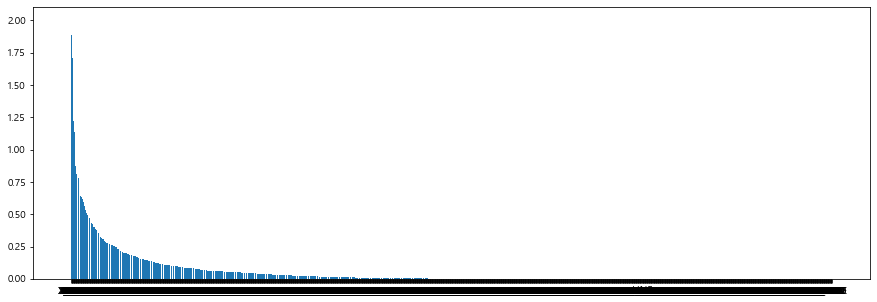

In [118]:
clf = catboost.CatBoostClassifier(learning_rate=0.05, iterations=5000, verbose=1000, task_type="GPU") # cpu -> thread_count=5
clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

feature_imp = pd.Series(clf.feature_importances_, index=train_x.columns).sort_values(ascending=False)[:]

plt.rcParams["figure.figsize"] = (15,5)
plt.bar(feature_imp.index, feature_imp)
plt.show()

In [148]:
perm = PermutationImportance(clf, n_iter=3).fit(x_val, y_val)
eli5.show_weights(perm, feature_names = x_val.columns.tolist())

Weight,Feature
0.0168 ± 0.0000,X_248
0.0140 ± 0.0079,X_73
0.0112 ± 0.0079,X_1665
0.0084 ± 0.0000,X_368
0.0084 ± 0.0000,X_947
0.0084 ± 0.0000,X_1532
0.0084 ± 0.0000,X_1743
0.0056 ± 0.0079,X_1083
0.0056 ± 0.0079,X_1569
0.0028 ± 0.0079,X_1106


In [149]:
train_x = train_x[train_x.columns[perm.feature_importances_ > 0]]
test = test[train_x.columns]
train_x.head()

,X_73,X_248,X_368,X_397,X_947,X_1083,X_1106,X_1192,X_1518,X_1532,X_1569,X_1665,X_1743
0,0.0,0.0,0.0,0.0,61.0,28.7,137.055556,910.0,12.244898,9.148148,486.677419,12.2,9.91
1,0.0,0.0,0.0,0.0,61.0,28.0,137.094340,910.0,7.830040,8.038384,486.593750,12.0,4.59
2,0.0,0.0,0.0,0.0,61.0,28.8,137.113207,960.0,10.958333,8.777778,486.645161,11.9,9.95
3,0.0,0.0,0.0,0.0,61.0,28.1,137.056604,910.0,11.803571,9.000000,486.531250,12.5,4.61
4,0.0,0.0,0.0,0.0,50.0,26.8,137.592593,920.0,12.020408,9.666667,486.935484,11.8,9.92


In [152]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(learning_rate=0.05, iterations=500, verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))

print(f1_list, np.mean(f1_list))

10it [00:47,  4.78s/it]

[0.7163163897034864, 0.6875, 0.6299043215822256, 0.7152752473832744, 0.5321274961597542, 0.6591896619829581, 0.6954365079365079, 0.6345570633227893, 0.6628796873763191, 0.5372493734335839] 0.6470435748880898


In [157]:
def Borderline_SMOTE_Class(train_x_df, train_y_df):
    B_SMOTE = BorderlineSMOTE()
    x_b_smote, y_b_smote = B_SMOTE.fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

In [156]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    x_trn, y_trn = Borderline_SMOTE_Class(x_trn, y_trn)
    clf = catboost.CatBoostClassifier(learning_rate=0.04, iterations=2500, verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))

print(f1_list, np.mean(f1_list))

5it [02:06, 25.22s/it]

[0.7233590733590733, 0.6871159744332133, 0.6572185521607486, 0.6745098039215686, 0.536036678329732] 0.6556480164408671


In [72]:
for train_x, train_y, test_x in zip([train_x_A, train_x_T], [train_y_A, train_y_T], [test_x_A, test_x_T]):
    train_x, train_y = Borderline_SMOTE_Class(train_x, train_y)
    clf = catboost.CatBoostClassifier(verbose=0).fit(train_x, train_y)
    pred = clf.predict(test_x)
    
    for i, idx in enumerate(test_x.index):
        subm['Y_Class'][idx] = pred[i]

        
        
clf = catboost.CatBoostClassifier(verbose=0, thread_count=5).fit(train_x_O, train_y_O)
pred = clf.predict(test_x_O)

for i, idx in enumerate(test_x_O.index):
    subm['Y_Class'][idx] = pred[i]

In [73]:
subm.Y_Class.value_counts()

1    276
0     32
2      2
Name: Y_Class, dtype: int64

In [27]:
subm.to_csv('./submission_30.csv', index=False)